# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

# Usage: 
1. run function pre_processing() to generate NEWSPAPER list
2. run generate_contact_sheet(keyword) and pass in argument keyword to generate final output 

In [1]:
import zipfile
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from kraken import binarization, pageseg
import pytesseract
import cv2
import numpy as np

TEXT_FONT = 18
fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", TEXT_FONT)
THUMBNAIL_SIZE = (120,120)
PADDING = 10
NEWSPAPER = list() # list of {'filename':str, 'words':str, 'faces':[]}

def extract_words(img):
    words = ''
    bounding_box = pageseg.segment(binarization.nlbin(img, threshold=0.2), black_colseps=True)['boxes']
    for box in bounding_box:
        cur_img = img.crop(box)
        words += pytesseract.image_to_string(cur_img)
    return words

def extract_faces(img):
    faces = list()
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    face_cascade = cv2.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
    face_box = face_cascade.detectMultiScale(grey, scaleFactor=1.3, minNeighbors=5, minSize=(30,30))
    for box in face_box:
        faces.append(img[box[1]:box[1]+box[3],box[0]:box[0]+box[2]])
    return faces

def pre_processing():
    with zipfile.ZipFile('readonly/images.zip', 'r') as myzip:
        for file_obj in myzip.infolist():
            filename = file_obj.filename
            with myzip.open(file_obj) as file:
                pil_img = Image.open(file).convert('RGB')
                opencv_img = np.array(pil_img) # RGB
                words = extract_words(pil_img.convert('L'))
                faces = extract_faces(opencv_img)
            NEWSPAPER.append({'filename':filename, 'words':words, 'faces':faces})

def generate_contact_sheet(keyword):
    result = [page for page in NEWSPAPER if keyword in page['words']]
    content_to_draw = list()
    content_to_draw_height = list()
    for page in result:
        filename = page['filename']
        string1 = f'Results found in file {filename}'
        face_sheet = None
        string2 = None
        if len(page['faces'])>0:
            rel_x = 0
            rel_y = 0
            num_row = len(page['faces'])//5 if len(page['faces'])%5 == 0 else len(page['faces'])//5 + 1
            face_sheet = Image.new('RGB', (THUMBNAIL_SIZE[0]*5,THUMBNAIL_SIZE[1]*num_row))
            for face in page['faces']:
                face = Image.fromarray(face) # convert opencv image to pil image
                face.thumbnail(THUMBNAIL_SIZE)
                face_sheet.paste(face, (rel_x, rel_y))
                rel_x = (rel_x + THUMBNAIL_SIZE[0]) % (THUMBNAIL_SIZE[0]*5)
                if rel_x == 0: rel_y += THUMBNAIL_SIZE[1]
        else:
            string2 = 'But there were no faces in that file!'
        for item in [string1, string2, face_sheet]:
            if not item is None:
                if len(content_to_draw) > 0 and isinstance(item, str) and isinstance(content_to_draw[-1], str):
                    content_to_draw[-1] += ('\n' + item)
                    content_to_draw_height[-1] += TEXT_FONT
                else:
                    content_to_draw.append(item)
                    content_to_draw_height.append(TEXT_FONT if isinstance(item, str) else item.size[1])
   
    contact_sheet_size = (THUMBNAIL_SIZE[0]*5 + PADDING*2, sum(content_to_draw_height) + len(content_to_draw)*PADDING*2)

    contact_sheet = Image.new('RGB', contact_sheet_size, color='white')
    cursor_x = PADDING
    cursor_y = PADDING
    for i in range(len(content_to_draw)):
        if isinstance(content_to_draw[i], str):
            ImageDraw.Draw(contact_sheet).text((cursor_x, cursor_y), content_to_draw[i], font=fnt, fill='black')
        else:
            contact_sheet.paste(content_to_draw[i], (cursor_x,cursor_y))

        cursor_y += (content_to_draw_height[i] + PADDING*2)

    display(contact_sheet)

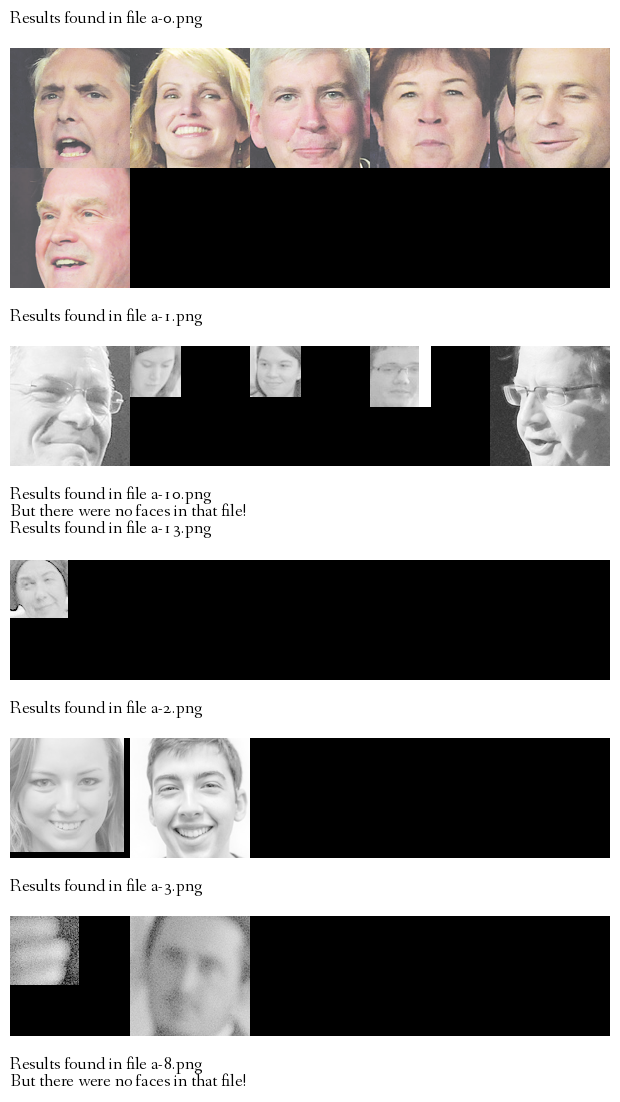

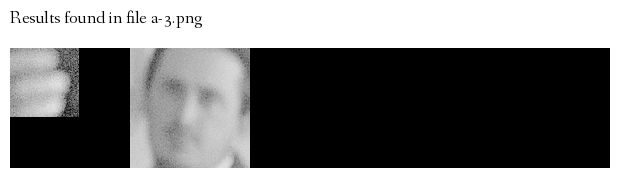

In [2]:
pre_processing()
generate_contact_sheet('Mark')
generate_contact_sheet('Christopher')
